## Importing libraries and reading dataset

In [1]:
import cv2
import os
import numpy as np
from tqdm import tqdm
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

data_path = 'Skin Cancer Dataset/'
categories = os.listdir(data_path)
labels = [i for i in range(len(categories))]
label_dict = dict(zip(categories, labels))  
print(label_dict)
print(categories)
print(labels)

{'Acitinic Keratosis': 0, 'Basal Cell Carcinoma': 1, 'Melanoma': 2, 'Nevus': 3, 'Pigmented Benign Keratosis': 4, 'Seborrheic Keratosis': 5}
['Acitinic Keratosis', 'Basal Cell Carcinoma', 'Melanoma', 'Nevus', 'Pigmented Benign Keratosis', 'Seborrheic Keratosis']
[0, 1, 2, 3, 4, 5]


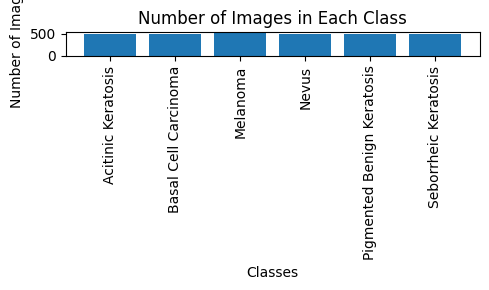

In [2]:
import os
import matplotlib.pyplot as plt

class_counts = {}

for category in categories:
    class_path = os.path.join(data_path, category)
    num_images = len(os.listdir(class_path))
    class_counts[category] = num_images

plt.figure(figsize=(5, 3))  # Increase the figure width
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Number of Images in Each Class')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)  # Increase rotation angle for better alignment
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

## Resizing and converting images into greyscale

In [3]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# Image size and category definitions
img_size = 224
categories = ['Acitinic Keratosis', 'Basal Cell Carcinoma', 'Melanoma', 
              'Nevus', 'Pigmented Benign Keratosis', 'Seborrheic Keratosis']
label_dict = {'Acitinic Keratosis': 0, 
              'Basal Cell Carcinoma': 1, 
              'Melanoma': 2, 
              'Nevus': 3, 
              'Pigmented Benign Keratosis': 4, 
              'Seborrheic Keratosis': 5}

def load_data_from_folder(data_path):
    data = []
    labels = []
    for category in tqdm(categories, desc="Processing categories"):
        folder_path = os.path.join(data_path, category)
        if not os.path.isdir(folder_path):
            print(f"Folder {folder_path} does not exist!")
            continue
        img_names = os.listdir(folder_path)
        for img_name in img_names:
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)  # Read image in color
            if img is None:
                continue
            try:
                resized_image = cv2.resize(img, (img_size, img_size))
                data.append(resized_image)
                labels.append(label_dict[category])
            except Exception as e:
                print("Exception:", e)
    return np.array(data), np.array(labels)

# Define paths for original and synthetic data
orig_data_path = 'Skin Cancer Dataset/'
synthetic_data_path = 'synthetic_data/'

# Load original images
orig_data, orig_labels = load_data_from_folder(orig_data_path)
print("Original data shape:", orig_data.shape)
print("Original labels shape:", orig_labels.shape)

# Load synthetic images
synthetic_data, synthetic_labels = load_data_from_folder(synthetic_data_path)
print("Synthetic data shape:", synthetic_data.shape)
print("Synthetic labels shape:", synthetic_labels.shape)

# Combine the original and synthetic datasets
combined_data = np.concatenate((orig_data, synthetic_data), axis=0)
combined_labels = np.concatenate((orig_labels, synthetic_labels), axis=0)

print("Combined data shape:", combined_data.shape)
print("Combined labels shape:", combined_labels.shape)


Processing categories: 100%|██████████| 6/6 [01:17<00:00, 12.97s/it]


Original data shape: (3005, 224, 224, 3)
Original labels shape: (3005,)


Processing categories: 100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


Synthetic data shape: (2995, 224, 224, 3)
Synthetic labels shape: (2995,)
Combined data shape: (6000, 224, 224, 3)
Combined labels shape: (6000,)


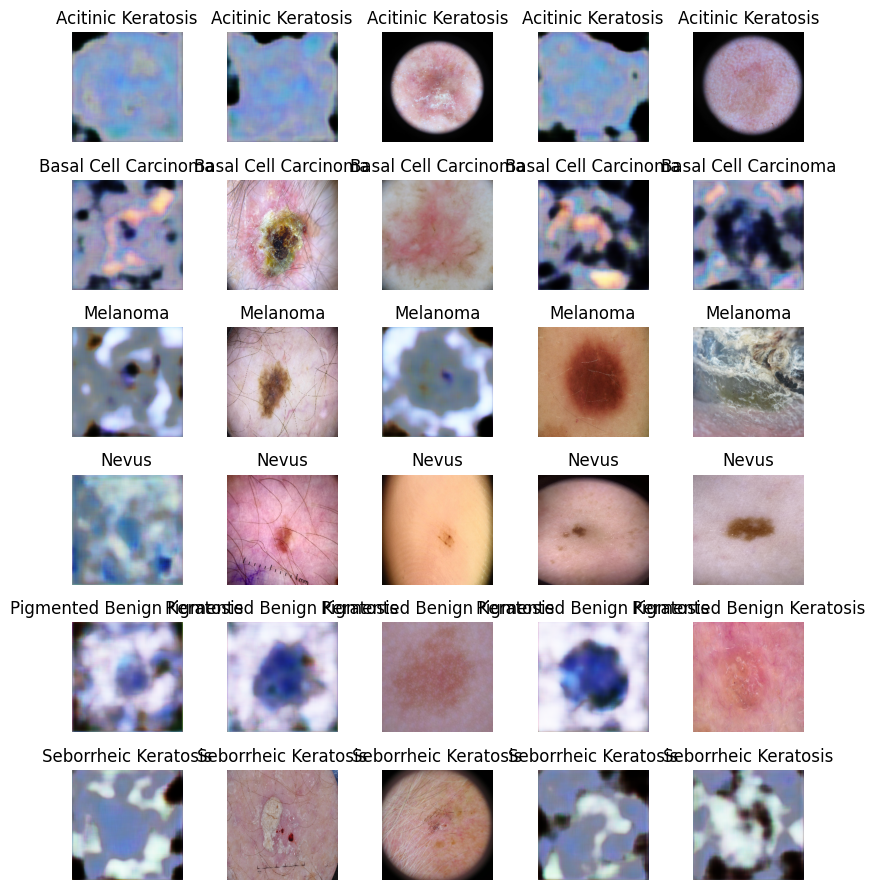

In [4]:
def display_random_images_per_class(data, labels, categories, num_samples=5):
    plt.figure(figsize=(8, len(categories) * 1.5))  # Adjust figure size based on the number of categories
    
    for class_idx, category in enumerate(categories):
        # Get indices of images belonging to the current class
        class_indices = np.where(labels == class_idx)[0]
        
        # Randomly select a specified number of indices for images in this class
        selected_indices = np.random.choice(class_indices, size=min(num_samples, len(class_indices)), replace=False)
        
        for i, idx in enumerate(selected_indices):
            plt.subplot(len(categories), num_samples, class_idx * num_samples + i + 1)
            plt.imshow(cv2.cvtColor(data[idx], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
            plt.axis('off')
            plt.title(f'{category}')  # Display the category and image index
    
    plt.tight_layout()
    plt.show()

# Display random images from each class in the training dataset
display_random_images_per_class(combined_data, combined_labels, categories, num_samples=5)

In [5]:
train_data = np.array(combined_data) / 255.0
# train_data = np.stack((train_data,) * 3, axis=-1)  # stack grayscale images to create 3 channels
train_labels = np.array(combined_labels)
train_labels = to_categorical(train_labels)

## Resnet50

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import ResNet50V2

img_size = 224

# Load the pre-trained ResNet50V2 model
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the layers in the base ResNet50V2 model
for layer in base_model.layers:
    layer.trainable = False

# Create the model architecture
x = base_model.output
x = Flatten()(x)

# Additional Dense and Dropout Layers
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)

# Output Layer
predictions = Dense(len(categories), activation='softmax')(x)

# Define the input and output of the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [7]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80-20 split, for example)
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

# Display the shapes of the resulting datasets
print(f"Training data shape: {train_data.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Testing data shape: {test_data.shape}")
print(f"Testing labels shape: {test_labels.shape}")

Training data shape: (4800, 224, 224, 3)
Training labels shape: (4800, 6)
Testing data shape: (1200, 224, 224, 3)
Testing labels shape: (1200, 6)


In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Set up the ReduceLROnPlateau scheduler for validation loss
lr_scheduler_loss = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.5,
                                       patience=5,
                                       verbose=1,
                                       min_lr=1e-6)

# Set up the ReduceLROnPlateau scheduler for validation accuracy
lr_scheduler_accuracy = ReduceLROnPlateau(monitor='val_accuracy',
                                           factor=0.5,
                                           patience=5,
                                           verbose=1,
                                           min_lr=1e-6)

# Define model checkpoint callback to save the best model during training
checkpoint = ModelCheckpoint("models/resnet_model.keras", monitor='val_loss', save_best_only=True)

# Train the model with early stopping and model checkpoint callbacks
history_resnet =  model.fit(train_data, train_labels, 
                        epochs=50, 
                        validation_data=(test_data, test_labels),
                        callbacks=[lr_scheduler_loss, lr_scheduler_accuracy, checkpoint])

Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 133s 835ms/step - accuracy: 0.3373 - loss: 1.6670 - val_accuracy: 0.6875 - val_loss: 0.8560 - learning_rate: 0.0010
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 119s 795ms/step - accuracy: 0.5817 - loss: 1.1176 - val_accuracy: 0.7175 - val_loss: 0.7524 - learning_rate: 0.0010
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 119s 792ms/step - accuracy: 0.6466 - loss: 0.9441 - val_accuracy: 0.7492 - val_loss: 0.6656 - learning_rate: 0.0010
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 120s 802ms/step - accuracy: 0.7027 - loss: 0.7902 - val_accuracy: 0.7567 - val_loss: 0.6348 - learning_rate: 0.0010
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 141s 792ms/step - accuracy: 0.7344 - loss: 0.7166 - val_accuracy: 0.7833 - val_loss: 0.5977 - learning_rate: 0.0010
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 118s 788ms/step - accuracy: 0.7552 - loss: 0.6589 - val_accuracy: 0.7833 - val_loss: 0.5801 - learning_rate: 0.0010
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 142s 787ms/step - accura

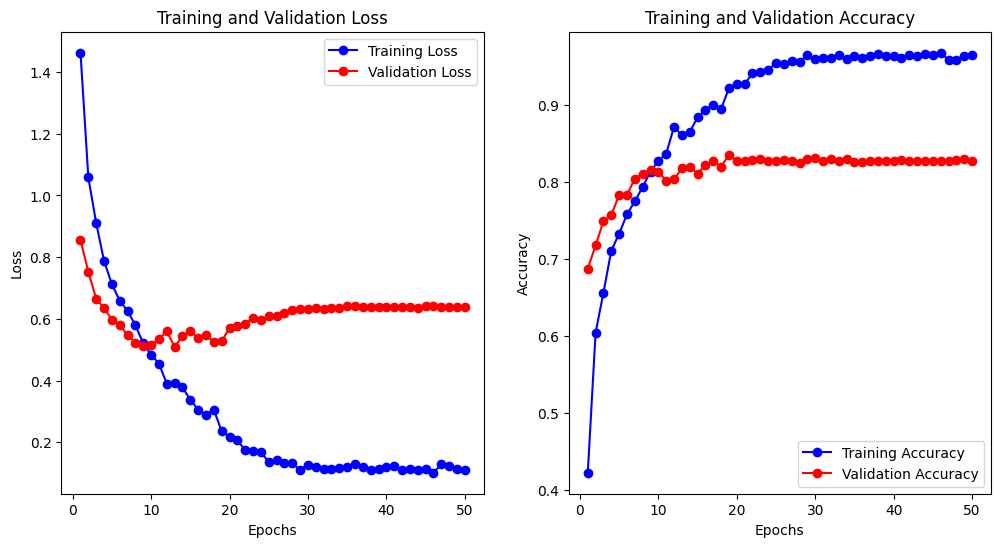

In [9]:
# Learning Curve
train_loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']
train_accuracy = history_resnet.history['accuracy']
val_accuracy = history_resnet.history['val_accuracy'] 
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score

# 1. Training and Validation Metrics
# Retrieve accuracy and loss for training and validation from history object
train_acc = history_resnet.history['accuracy'][-1]  # last epoch training accuracy

# 2. Testing Metrics
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=0)

# Predict on the test set
y_pred = model.predict(test_data)
y_pred_classes = y_pred.argmax(axis=1)  # Convert probabilities to class labels
y_true = test_labels.argmax(axis=1)  # If y_test is one-hot encoded, convert to class labels

# 3. Precision, Recall, F1 Score for Testing Set
precision = precision_score(y_true, y_pred_classes, average='weighted')  # 'weighted' for multi-class
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Print Results
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 27s 689ms/step
Training Accuracy: 0.9652
Test Accuracy: 0.8267
Precision: 0.8259
Recall: 0.8267
F1 Score: 0.8260


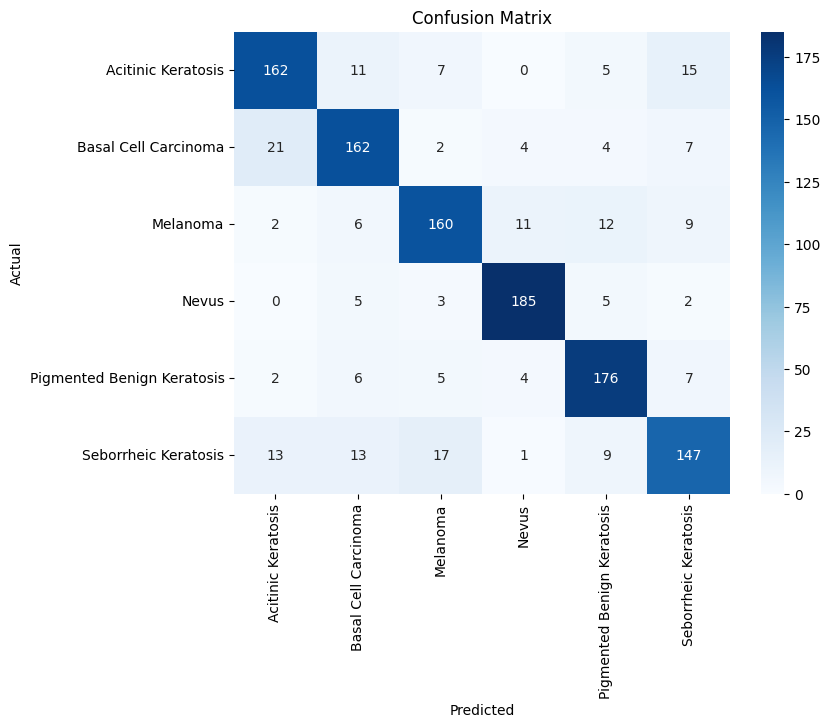

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

<!-- Normal - 64, 63, 69 (batch 32)
Clahe - 66, 65, 68 (batch 32)
Clahe + Hist - 69, 65, 70 (batch 32)
Clahe + Hist + Gamma - 71, 65, 71 (batch 32)
Clahe + Hist + Gamma - 80, 68, 72 (batch 16)
Clahe + Hist + Gamma + augmentation - 87, 57, 58 (batch 16) -->